In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
admission_data = pd.read_csv('../b. Datasets/GraduateAdmissions/GraduateAdmissions.csv')

In [3]:
display(admission_data.head(2))
display(admission_data.tail(2))

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,1
1,2,324,107,4,4.0,4.5,8.87,1,1


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
398,399,312,103,3,3.5,4.0,8.78,0,0
399,400,333,117,4,5.0,4.0,9.66,1,1


In [4]:
admission_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Serial No.,400.0,200.500000,115.614301,1.0,100.75,200.50,300.2500,400.00
GRE Score,400.0,316.807500,11.473646,290.0,308.00,317.00,325.0000,340.00
TOEFL Score,400.0,107.410000,6.069514,92.0,103.00,107.00,112.0000,120.00
University Rating,400.0,3.087500,1.143728,1.0,2.00,3.00,4.0000,5.00
SOP,400.0,3.400000,1.006869,1.0,2.50,3.50,4.0000,5.00
LOR,400.0,3.452500,0.898478,1.0,3.00,3.50,4.0000,5.00
CGPA,400.0,8.598925,0.596317,6.8,8.17,8.61,9.0625,9.92
Research,400.0,0.547500,0.498362,0.0,0.00,1.00,1.0000,1.00
Chance of Admit,400.0,0.450000,0.498117,0.0,0.00,0.00,1.0000,1.00


In [5]:
admission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 28.3 KB


##### Research field is supposed to be true/false type feature. Here, it is being considered as an integer. Should be converted.

In [6]:
admission_data['Research'] = admission_data['Research'].astype('object')
admission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    object 
 8   Chance of Admit    400 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 28.3+ KB


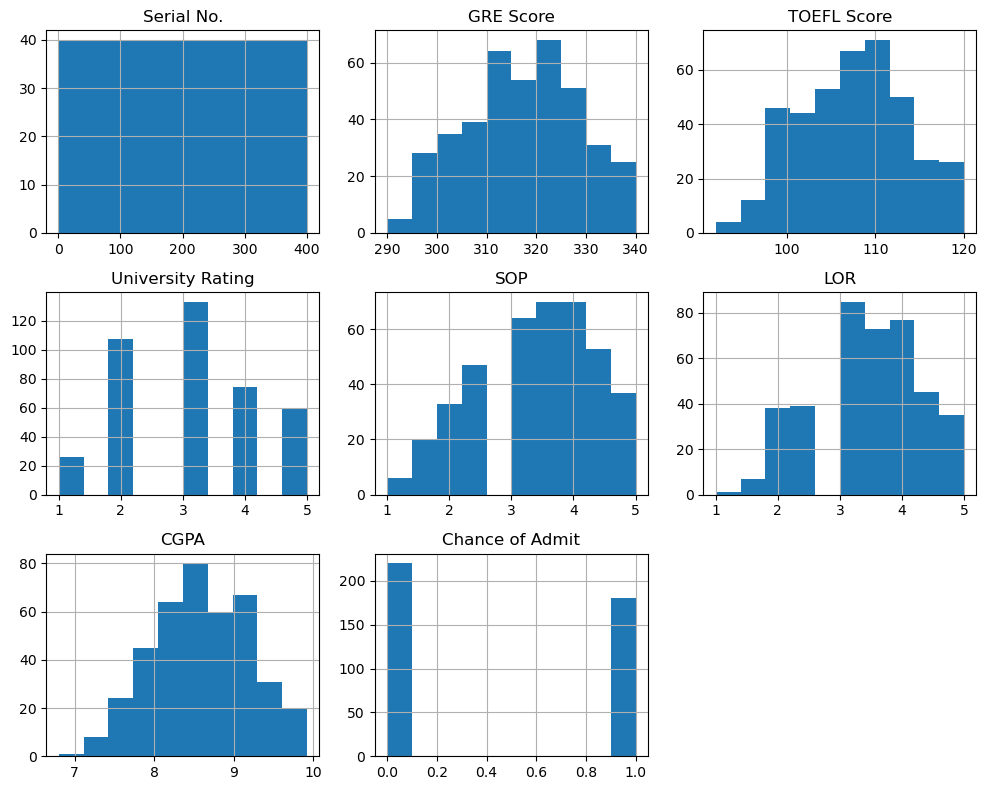

In [7]:
admission_data.select_dtypes(include='number').hist(figsize=(10, 8))
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
admission_data.skew()

Serial No.                0.0
GRE Score           -0.062893
TOEFL Score          0.057216
University Rating     0.17126
SOP                 -0.275761
LOR                 -0.106991
CGPA                -0.065991
Research            -0.191582
Chance of Admit      0.201765
dtype: object

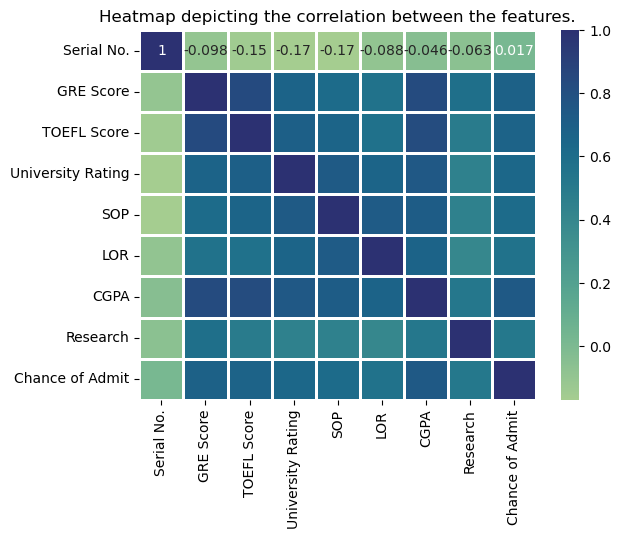

In [9]:
sns.heatmap(admission_data.corr(), cmap='crest', annot=True, linewidths=0.8)
plt.title("Heatmap depicting the correlation between the features.")
plt.show()

In [10]:
sum_of_nans = admission_data.isna().sum()
percentage_of_nans = admission_data.isna().sum() / admission_data.shape[0] * 100
features = admission_data.columns

missing_value_data = pd.concat([sum_of_nans, percentage_of_nans], keys=["Sum of NANs", "Percentage of NANs"], axis=1)
display(missing_value_data)

,Sum of NANs,Percentage of NANs
Serial No.,0,0.0
GRE Score,0,0.0
TOEFL Score,0,0.0
University Rating,0,0.0
SOP,0,0.0
LOR,0,0.0
CGPA,0,0.0
Research,0,0.0
Chance of Admit,0,0.0


In [11]:
research_encoded = pd.get_dummies(data=admission_data['Research'], prefix='Research')
research_encoded.reset_index()
research_encoded.head(2)

,Research_0,Research_1
0,False,True
1,False,True


In [12]:
admission_data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,1
1,2,324,107,4,4.0,4.5,8.87,1,1
2,3,316,104,3,3.0,3.5,8.00,1,0
3,4,322,110,3,3.5,2.5,8.67,1,1
4,5,314,103,2,2.0,3.0,8.21,0,0
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,1
396,397,325,107,3,3.0,3.5,9.11,1,1
397,398,330,116,4,5.0,4.5,9.45,1,1
398,399,312,103,3,3.5,4.0,8.78,0,0


In [13]:
admission_data.drop(labels='Research', axis=1, inplace=True)
admission_data = pd.concat([admission_data, research_encoded], axis=1)
admission_data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_0,Research_1
0,1,337,118,4,4.5,4.5,9.65,1,False,True
1,2,324,107,4,4.0,4.5,8.87,1,False,True
2,3,316,104,3,3.0,3.5,8.00,0,False,True
3,4,322,110,3,3.5,2.5,8.67,1,False,True
4,5,314,103,2,2.0,3.0,8.21,0,True,False
...,...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,False,True
396,397,325,107,3,3.0,3.5,9.11,1,False,True
397,398,330,116,4,5.0,4.5,9.45,1,False,True
398,399,312,103,3,3.5,4.0,8.78,0,True,False


In [14]:
admission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Chance of Admit    400 non-null    int64  
 8   Research_0         400 non-null    bool   
 9   Research_1         400 non-null    bool   
dtypes: bool(2), float64(3), int64(5)
memory usage: 25.9 KB


In [15]:
target_data = admission_data['Chance of Admit']
admission_data = admission_data.drop('Chance of Admit', axis=1)
feature_names = admission_data.columns
standard_scaler = StandardScaler()
admission_data = standard_scaler.fit_transform(admission_data)
admission_data = pd.DataFrame(admission_data, columns=feature_names)
admission_data = pd.concat([admission_data, target_data], axis=1)
admission_data.drop('Research_1', axis=1, inplace=True)
admission_data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research_0,Chance of Admit
0,-1.727726,1.762107,1.746971,0.798829,1.093864,1.167321,1.764818,-0.909112,1
1,-1.719066,0.627656,-0.067635,0.798829,0.596653,1.167321,0.455151,-0.909112,1
2,-1.710406,-0.070467,-0.562528,-0.076600,-0.397769,0.052933,-1.005631,-0.909112,0
3,-1.701745,0.453126,0.427257,-0.076600,0.099442,-1.061454,0.119339,-0.909112,1
4,-1.693085,-0.244998,-0.727492,-0.952029,-1.392191,-0.504260,-0.653029,1.099975,0
...,...,...,...,...,...,...,...,...,...
395,1.693085,0.627656,0.427257,-0.076600,0.099442,0.052933,0.740592,-0.909112,1
396,1.701745,0.714922,-0.067635,-0.076600,-0.397769,0.052933,0.858126,-0.909112,1
397,1.710406,1.151249,1.417042,0.798829,1.591075,1.167321,1.429006,-0.909112,1
398,1.719066,-0.419528,-0.727492,-0.076600,0.099442,0.610127,0.304036,1.099975,0


In [16]:
X = admission_data.drop('Chance of Admit', axis=1)
y = admission_data['Chance of Admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 8), (80, 8), (320,), (80,))

In [18]:
logistic_regression = sm.Logit(y_train, X_train).fit()
print(logistic_regression.summary())

Optimization terminated successfully.
         Current function value: 0.247833
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        Chance of Admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                            7
Date:                Thu, 31 Oct 2024   Pseudo R-squ.:                  0.6410
Time:                        22:06:43   Log-Likelihood:                -79.307
converged:                       True   LL-Null:                       -220.91
Covariance Type:            nonrobust   LLR p-value:                 2.333e-57
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Serial No.            0.4983      0.230      2.164      0.030       0.047       0.950
GRE Scor

In [19]:
logistic_regression.aic

174.6133013144106

In [20]:
odds_data = pd.DataFrame(np.exp(logistic_regression.params), columns= ['Odds']) 
odds_data

,Odds
Serial No.,1.645901
GRE Score,1.571478
TOEFL Score,1.485069
University Rating,1.621948
SOP,1.853663
LOR,1.414972
CGPA,9.673183
Research_0,0.683303


This means that the odds of obtaining an admission increases by a factor of X (Whatever value of odds is obtained) due to one unit increase in the said feature while the other variables are constant.

In [21]:
y_train_pred = logistic_regression.predict(X_train)
y_test_pred = logistic_regression.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Train RMSE is {train_rmse}.')
print(f'Test RMSE is {test_rmse}.')

Train RMSE is 0.2807097845702583.
Test RMSE is 0.3244781420148563.


In [22]:
threshold = 0.5
y_test_pred_binary = (y_test_pred >= threshold).astype(int)
submission_dataframe = pd.DataFrame({
    'index': X_test.index,
    'Chance of Admit': y_test_pred_binary
})
submission_dataframe.head(2)

,index,Chance of Admit
132,132,0
309,309,1


In [23]:
submission_dataframe_file = '../d. Output Files/GraduateAdmissions/' + 'GraduateAdmissions_Prediction.csv'
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: GraduateAdmissions_Prediction.csv
